In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import polyflexmd.data_analysis.plot.msd as msd_plot

sns.set_style("darkgrid")

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12,9)

In [24]:
3*10**(-4)

0.00030000000000000003

In [25]:
def read(path):
    df_msd_lm = pd.read_csv(path)
    df_msd_lm["t/LJ"] = df_msd_lm["t"] * 0.0025
    df_msd_lm["t/LJ"] = df_msd_lm["t/LJ"] - df_msd_lm["t/LJ"].min()
    return df_msd_lm

In [26]:
df_bare = read("/home/egor/Projects/polyflexmd/data/17/lm_msd.csv")
df_conn = read("/home/egor/Projects/polyflexmd/data/18/lm_msd.csv")
df_conn

,t,dr_N^2,delta dr_N^2,kappa,d_end,t/LJ
0,35000000,0.000000,0.000000,190.2,15.0,0.00
1,35000100,0.046958,0.005652,190.2,15.0,0.25
2,35000200,0.111074,0.012232,190.2,15.0,0.50
3,35000300,0.176430,0.020512,190.2,15.0,0.75
4,35000400,0.239394,0.027987,190.2,15.0,1.00
...,...,...,...,...,...,...
23796,74960000,8906.926347,980.914046,190.2,15.0,99900.00
23797,74970000,8915.309152,982.538678,190.2,15.0,99925.00
23798,74980000,8916.115272,980.072151,190.2,15.0,99950.00
23799,74990000,8942.174367,983.550062,190.2,15.0,99975.00


In [27]:
L_contour = 63 * .97

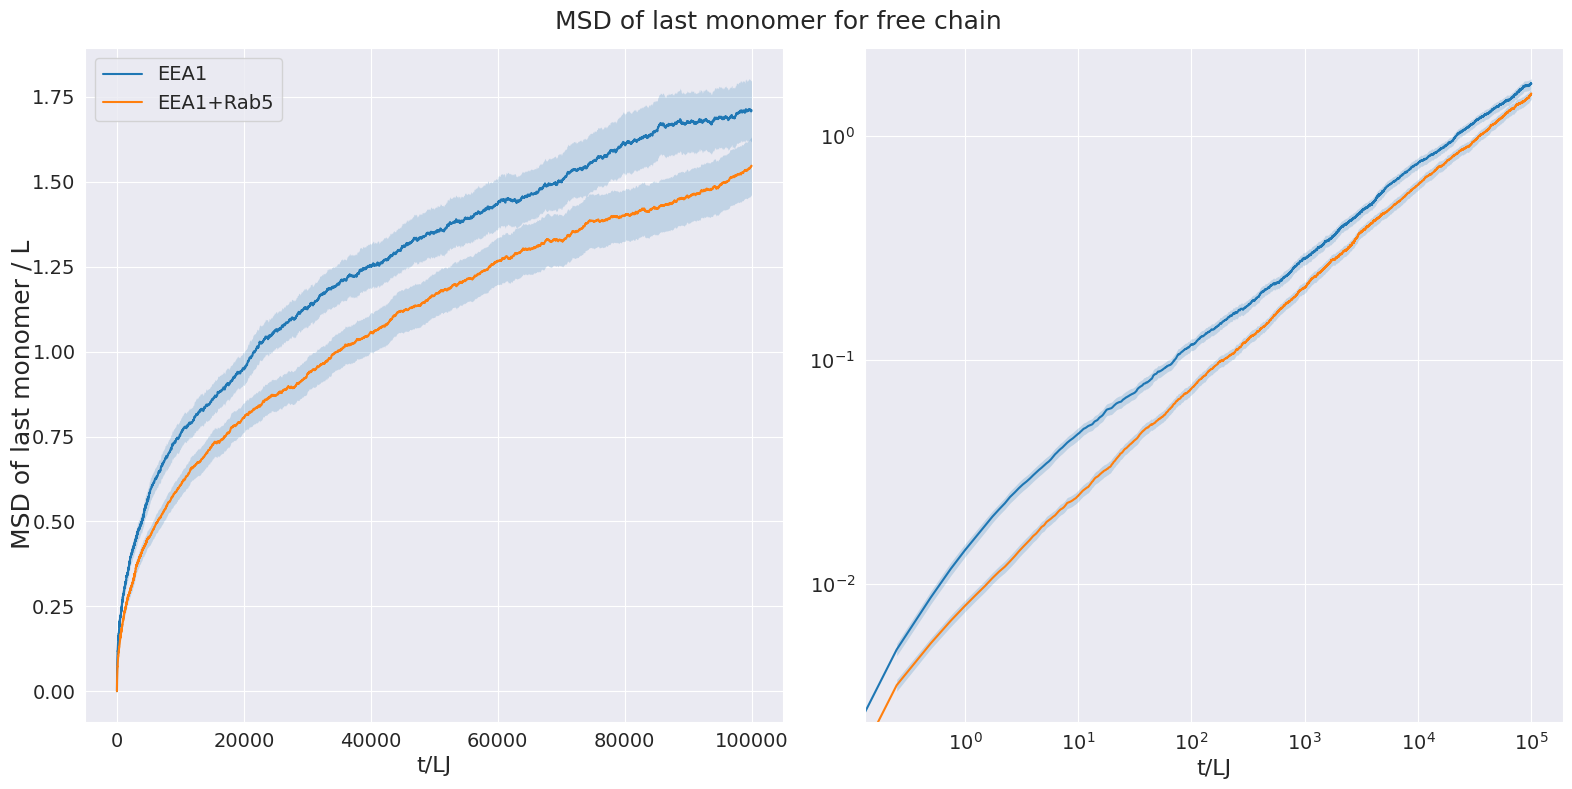

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

msd_plot.plot_MSD(
    df_bare,
    log_scale=False,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=1.0,
    col="dr_N^2",
    label="EEA1",
    ax=axs[0],
    title="",
    ylabel=""
)

msd_plot.plot_MSD(
    df_conn,
    log_scale=False,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=10.0,
    col="dr_N^2",
    label="EEA1+Rab5",
    ax=axs[0],
    title="",
    ylabel=""
)

msd_plot.plot_MSD(
    df_bare,
    log_scale=False,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=1.0,
    col="dr_N^2",
    label="EEA1",
    ax=axs[1],
    title="",
    ylabel=""
)

msd_plot.plot_MSD(
    df_conn,
    log_scale=True,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=10.0,
    col="dr_N^2",
    label="EEA1+Rab5",
    ax=axs[1],
    title="",
    ylabel=""
)

axs[0].legend()

fig.suptitle("MSD of last monomer for free chain")
fig.supylabel("MSD of last monomer / L")
fig.tight_layout()

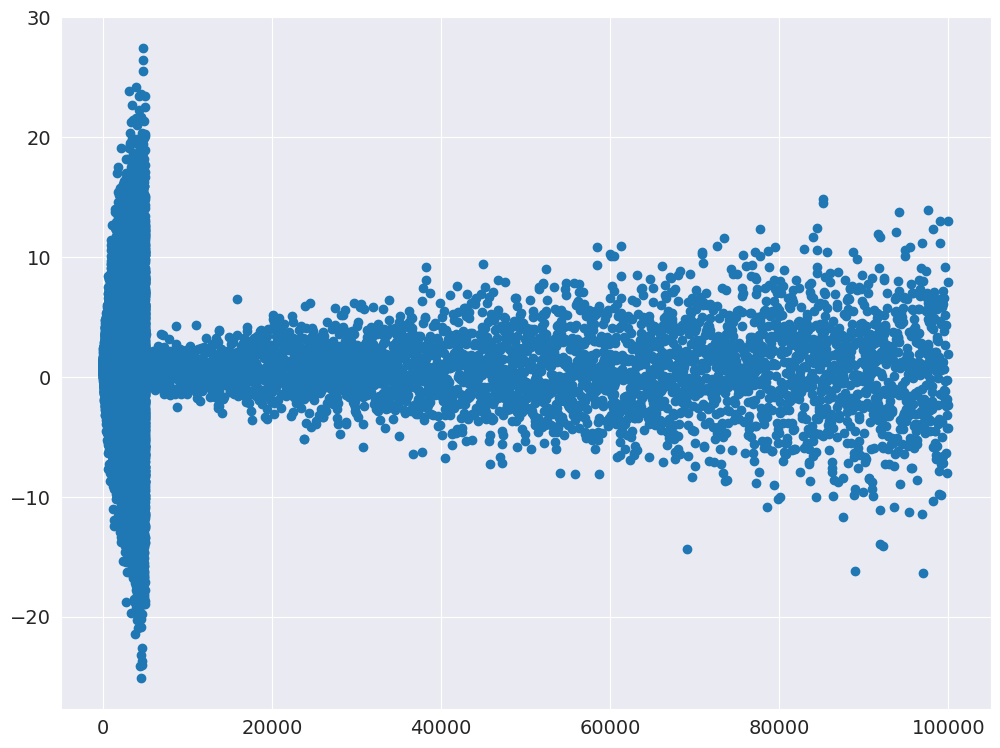

In [35]:
log_r = np.log10(df_bare["dr_N^2"].iloc[1:])
log_t = np.log10(df_bare["t/LJ"].iloc[1:])
dr = np.gradient(log_r, log_t)

plt.scatter(df_bare["t/LJ"].iloc[1:], dr)

In [44]:
import scipy.optimize
import numpy as np

def log_local_derivative(vals: pd.DataFrame):
    if vals.index[0] == 0:
        vals = vals.iloc[1:]
    t_log = np.log10(vals.index)
    r_log = np.log10(vals)
    t_log = t_log - t_log.min()
    r_log = r_log - r_log.min()
    f = lambda t, k: k*t 
    params,_ = scipy.optimize.curve_fit(f, t_log, r_log, p0=(0,))
    return params[0]

def log_rolling_derivative(df: pd.DataFrame, window=10):
    return df.set_index("t/LJ")["dr_N^2"].rolling(window=window).apply(log_local_derivative)

window_sizes = [100, 500, 1000, 5000, 10000]
alphas = []
for w_size in window_sizes:
    print(f"Processing {w_size}")
    alpha = log_rolling_derivative(df_bare, window=w_size)
    alphas.append(alpha)


Processing 100
Processing 500
Processing 1000
Processing 5000
Processing 10000


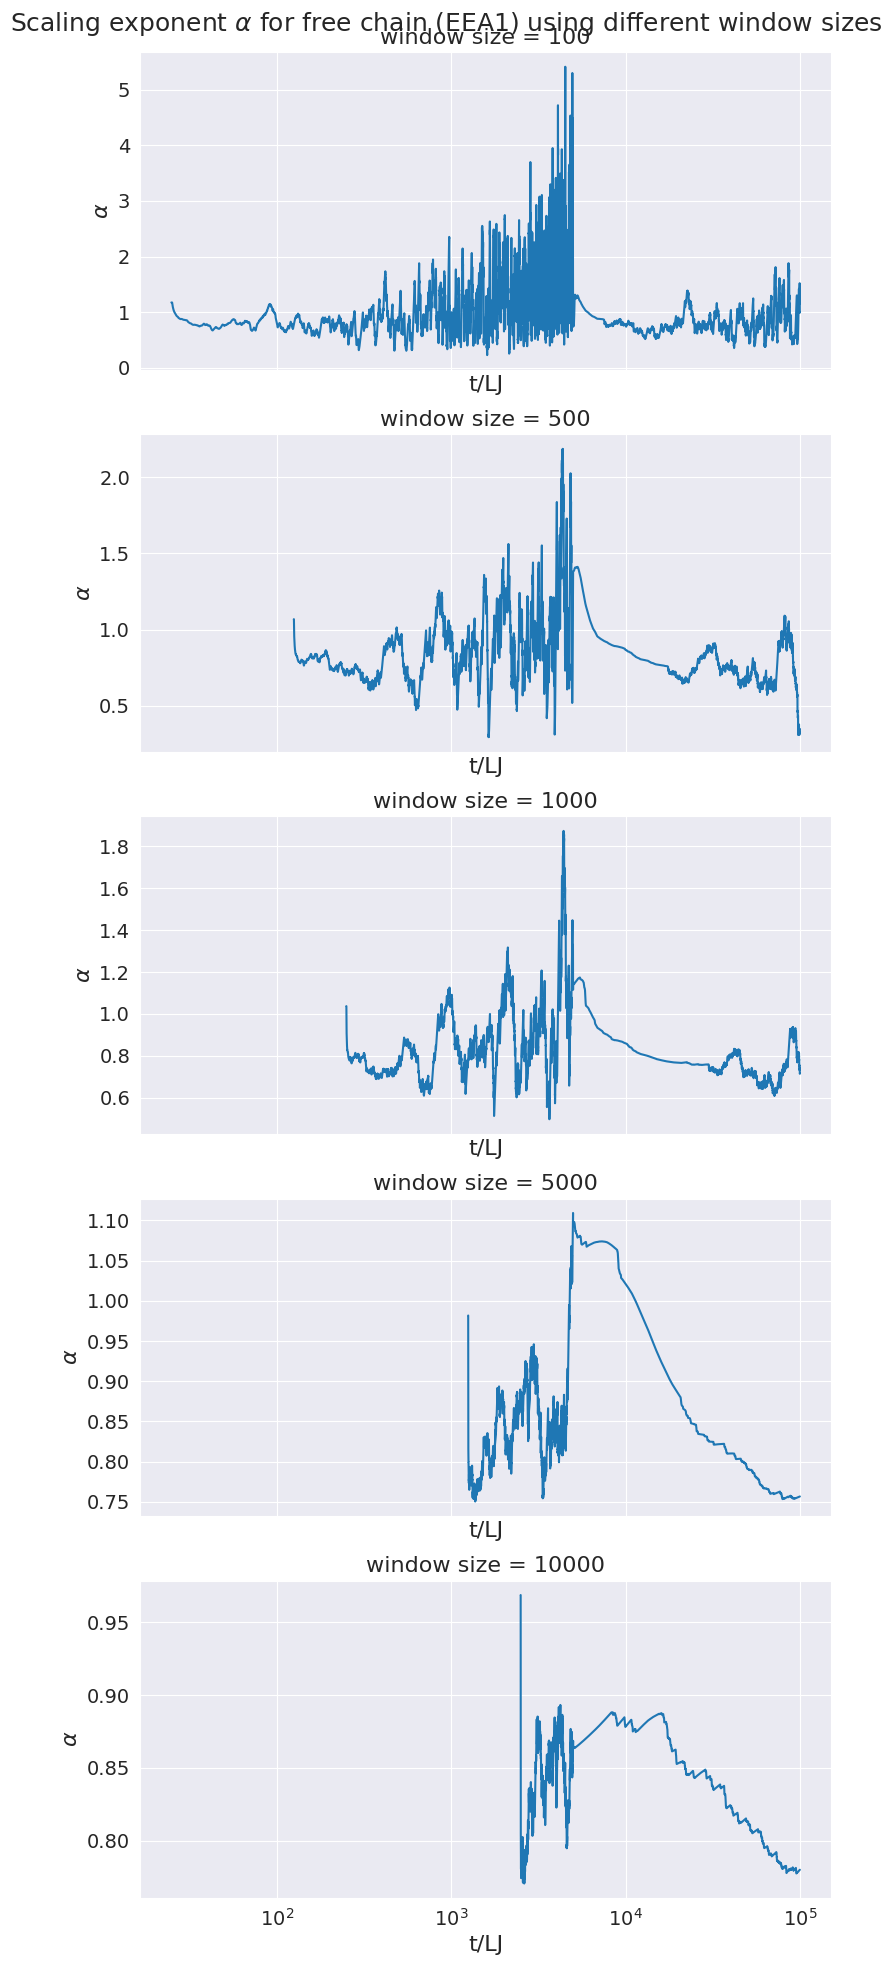

In [49]:
fig, axs = plt.subplots(nrows=len(window_sizes), figsize=(8, 4*len(window_sizes)), sharex="all")

for window_size, alpha, ax in zip(window_sizes, alphas, axs):
    ax.plot(alpha.index, alpha)
    ax.set(
        title=f"window size = {window_size}",
        xscale="log",
        ylabel="$\\alpha$",
        xlabel="t/LJ",
    )

fig.suptitle("Scaling exponent $\\alpha$ for free chain (EEA1) using different window sizes")

fig.tight_layout()


In [66]:
split_points = [0] + [10**i for i in range(6)]
split_points

[0, 1, 10, 100, 1000, 10000, 100000]

In [68]:
bins = pd.cut(df_msd_lm["t/LJ"], bins=split_points, include_lowest=True)
alphas = df_msd_lm.groupby(bins).apply(log_local_derivative)
alphas

t/LJ
(-0.001, 1.0]          1.477718
(1.0, 10.0]            0.989047
(10.0, 100.0]          0.798954
(100.0, 1000.0]        0.771759
(1000.0, 10000.0]      0.867029
(10000.0, 100000.0]    0.724458
dtype: float64

[None]

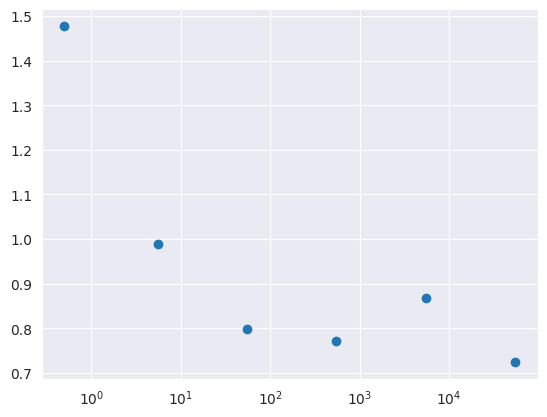

In [79]:
t_centers = alphas.index.map(lambda tup: tup.left + (tup.right-tup.left) / 2 ).to_numpy()
_, ax = plt.subplots()

ax.scatter(t_centers, alphas)
ax.set(xscale="log")

In [37]:
from pandas.core.indexers.objects import BaseIndexer



In [49]:
df_msd_lm.groupby(by=np.log10(df_msd_lm["t/LJ"]))["dr_N^2"].apply(log_local_derivative)

/home/egor/Projects/polyflexmd/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


t/LJ
-1.0    1.512369
 0.0    1.060498
Name: dr_N^2, dtype: float64